In [1]:
import pandas as pd
import tabulate as tab
import numpy as np
import matplotlib as mpt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sys
import pystan
import scipy
import pickle

In [2]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 50
%matplotlib inline

In [3]:

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.facecolor'] ="white"
plt.rcParams['grid.color'] ="grey"
plt.rcParams['grid.linestyle'] = "dotted"
plt.rcParams["axes.labelsize"]= 14
#plt.rcParams['figure.savefig.dpi'] = 100
plt.rcParams['savefig.edgecolor'] = "#f2f2f2"
plt.rcParams['savefig.facecolor'] ="white"
plt.rcParams["figure.figsize"] = [15,8]
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['font.size'] = 14
greens = ['#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
multi =['#66c2a4','#1f78b4','#a6cee3','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
#plt.rcParams["axes.color_cycle"] = multi


In [4]:
def get_percentiles(ser):
    return(np.percentile(ser, [2.5,15,50,85,97.5]))

def logit_to_prob(value):
    return(math.exp(value)/(1+math.exp(value)))

In [5]:
solar_data = pd.read_csv("/Users/johannesmauritzen/research/solar_files/prod_wide_clean.csv")

solar_data = solar_data[solar_data.prod_index.notnull()]
solar_data = solar_data[solar_data.months_operation.notnull()]

app_nums  = solar_data.app_num.unique()
installation=[i + 1 for i in range(0,len(app_nums))]
installations = pd.DataFrame({"app_num":app_nums, "installation":installation})
solar_data = solar_data.merge(installations, how="left", on="app_num")


/Users/johannesmauritzen/anaconda/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (29,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
solar_data = solar_data[solar_data.prod_index.notnull()]
solar_data = solar_data[solar_data.months_operation.notnull()]


In [42]:

solar_data["prod_end_date"] = pd.to_datetime(solar_data.prod_end_date)

In [8]:
#age of panel system in data
N = solar_data.count(axis=0)[0]

app_num = solar_data["app_num"]
unique_app_num = app_num.unique()
J = unique_app_num.size
L = 2

solar_data["log_prod_kwh"] = np.log(solar_data["prod_kwh"])


In [9]:
#observation data
log_prod_kwh = solar_data["log_prod_kwh"] 
month = solar_data["month"]


In [45]:
#installation level variables
installations = solar_data[["app_num", "installation", "cust_county", "sector", "tracking", "sys_size_dc", "third_party_owned", "installation_year"]][~solar_data.installation.duplicated()]


In [46]:
#lease variables
pd.get_dummies(solar_data["third_party_owned"])["yes"]
lease = pd.get_dummies(installations.third_party_owned)
lease = [int(i+1) for i in lease.yes]


In [47]:
#Add installation level effects county, sector random effect
counties = installations["cust_county"][~installations.cust_county.duplicated()]
C = len(counties)
county_num = [i + 1 for i in range(0,len(counties))]
county_dict = dict(zip(counties , county_num))
county_var = [county_dict[i] for i in installations.cust_county]

sector = installations["sector"][~installations.sector.duplicated()]
S = len(sector)
sector_num = [i + 1 for i in range(0,len(sector))]
sector_dict = dict(zip(sector, sector_num))
sector_var = [sector_dict[i] for i in installations.sector]

tracking = installations["tracking"][~installations.tracking.duplicated()]
T = len(tracking)
tracking_num = [i + 1 for i in range(0,len(tracking))]
tracking_dict = dict(zip(tracking, tracking_num))
tracking_var = [tracking_dict[i] for i in installations.tracking]


In [48]:
solar_stan_data = {"log_prod_kwh":solar_data["log_prod_kwh"],
"months_operation":solar_data["months_operation"],
"month": month,
"installation":solar_data["installation"],
"sys_size": installations["sys_size_dc"],
"installation_year":installations["installation_year"],
"lease":lease,
"county":county_var,
"tracking":tracking_var,
"sector":sector_var,
"N":N,
"J":J,
"L":L,
"M":12,
"C":C,
"S":S,
"T":T
}

In [16]:
# def initfun():
# 	return dict(a=.9, b_1=0, sigma=sd_prod_index, nuMinusOne=1) 


In [17]:
solar_stan = """

data{
	int<lower = 0> N; // number of observations
	int<lower = 0> J; //number of groups
	int<lower = 0> L; //lease/not lease =2
	int<lower = 0> M; //number of months
    int<lower = 0> C; //number of different counties
    int<lower = 0> S; //number of different sectors
    int<lower = 0> T; //number of different trackers
    
	int installation[N]; //Which of J installations does it belong too
	vector[N] log_prod_kwh; //response variable
	vector[N] months_operation; //main predictor
	int month[N]; // which of 12 months does it belong too.
    
	int lease[J]; //indicator variable for lease
    int county[J];
    int tracking[J];
    int sector[J];
    
    vector[J] sys_size; //size of system
    vector[J] installation_year; //year of installation
    
}

transformed data{
    vector[N] st_log_prod_kwh;
    vector[N] st_months_operation;
    
    vector[J] st_sys_size;
    vector[J] st_installation_year;
    
    st_log_prod_kwh <- (log_prod_kwh - mean(log_prod_kwh))/sd(log_prod_kwh);
    st_months_operation <- (months_operation - mean(months_operation))/sd(months_operation);
    st_sys_size <- (sys_size - mean(sys_size))/sd(sys_size);
    st_installation_year <- (installation_year - mean(installation_year))/sd(installation_year);
}

parameters{    
    real mu_b0;
	real mu_lease[2]; //varying slope, grouped by lease
	real re_b1[J];
    real re_b0[J];
	real mu_mon[M];
    real beta0_size;
    real beta1_size;
    real beta1_ins_year;
    
    real mu1_c[C];
    real mu1_s[S];
    real mu1_t[T];
    
    real mu0_c[C];
    real mu0_t[T];
    
	real<lower=0> sigma; //standard deviation
	real<lower=0> sigma_b0; //st.dev group level intercept
	real<lower=0> sigma_b1; //st. dev group level lease
    real<lower=0> sigma_mu_lease; //st. dev, mu
    
    real<lower=0> sigma_mu0_c; //st. dev, mu
    real<lower=0> sigma_mu0_t; //st. dev, mu

    real<lower=0> sigma_mu1_c; //st. dev, mu
    real<lower=0> sigma_mu1_s; //st. dev, mu
    real<lower=0> sigma_mu1_t; //st. dev, mu
    
    real<lower=0> sigma_mon; //
    
}

transformed parameters {
	real b1[J]; // varying slopes by group
    real b0[J]; // varying intercept by group
	real y_hat[N]; //individual means

	for (j in 1:J){
		b1[j]<-mu_lease[lease[j]] + mu1_s[sector[j]] + mu1_c[county[j]] + mu1_t[tracking[j]] + beta1_ins_year*st_installation_year[j] + re_b1[j];
	}
    
    for (j in 1:J){
        b0[j]<-beta0_size*st_sys_size[j] + mu0_c[county[j]] + mu0_t[tracking[j]] + re_b0[j];
    }
	
	for (i in 1:N){
		y_hat[i] <- b0[installation[i]] + b1[installation[i]]*st_months_operation[i] + mu_mon[month[i]];
	}	
}

model{		
    sigma_mu_lease ~ cauchy(0,5);
    sigma_mu0_c ~ cauchy(0, 5);
    sigma_mu0_t ~ cauchy(0, 5);
    
    sigma_mu1_c ~ cauchy(0, 5);
    sigma_mu1_s ~ cauchy(0, 5);
    sigma_mu1_t ~ cauchy(0, 5);
    
  	sigma_b1 ~ cauchy(0, 5);
  	sigma_b0 ~ cauchy(0, 5); // mu and sigma on b0 param.
    
    sigma_mon ~ cauchy(0,5);
	sigma ~ cauchy(0,5);

    to_vector(re_b0) ~ cauchy(0, sigma_b0); //vectorized, j 
  	to_vector(re_b1) ~ cauchy(0, sigma_b1); //vectorized, j 
	to_vector(mu_mon) ~ cauchy(0,sigma_mon); // vectorized, m
    to_vector(mu_lease) ~ cauchy(0, sigma_mu_lease); //vectorized,l 

    beta0_size~cauchy(0, 5);
    beta1_size~cauchy(0, 5);
    beta1_ins_year~cauchy(0, 5);
    
    to_vector(mu1_c)~ cauchy(0, sigma_mu1_c);
    to_vector(mu1_s)~ cauchy(0, sigma_mu1_s);
    to_vector(mu1_t)~ cauchy(0, sigma_mu1_t);
    
    to_vector(mu0_c)~ cauchy(0, sigma_mu0_c);
    to_vector(mu0_t)~ cauchy(0, sigma_mu0_t);

	st_log_prod_kwh ~ cauchy(y_hat, sigma); 
}
"""

In [18]:
#solar_fit = pystan.stan(model_code=solar_stan, 
#            data = solar_stan_data, iter=1000, chains=4)


In [25]:
#solar_extr = solar_fit.extract(permuted=True) 


In [26]:
#pickle.dump(solar_extr, open("/Users/johannesmauritzen/research/solar_files/solar4.pkl", 'wb')) 


In [19]:
import pickle
solar_extr = pickle.load(open("/Users/johannesmauritzen/research/solar_files/solar6.pkl", 'rb'))

In [20]:
solar_params = pd.DataFrame({"mu_own": solar_extr["mu_lease"][:,0],
	"mu_lease":solar_extr["mu_lease"][:,1],
	"sigma":solar_extr["sigma"],
    "beta0_size":solar_extr["beta0_size"],
    "beta1_size":solar_extr["beta1_size"],
    "beta1_ins_year":solar_extr["beta1_ins_year"],
    "mu1_commercial":solar_extr["mu1_s"][:,0],
    "mu1_government":solar_extr["mu1_s"][:,1],
    "mu1_residential":solar_extr["mu1_s"][:,2],
    "mu1_non_profit":solar_extr["mu1_s"][:,3],
    "mu1_not_tracking":solar_extr["mu1_t"][:,0],
    "mu1_tracking":solar_extr["mu1_t"][:,1],
	"jan":solar_extr["mu_mon"][:,0],
	"feb":solar_extr["mu_mon"][:,1],
	"mar":solar_extr["mu_mon"][:,2],
	"apr":solar_extr["mu_mon"][:,3],
	"may":solar_extr["mu_mon"][:,4],
	"jun":solar_extr["mu_mon"][:,5],
	"jul":solar_extr["mu_mon"][:,6],
	"aug":solar_extr["mu_mon"][:,7],
	"sep":solar_extr["mu_mon"][:,8],
	"oct":solar_extr["mu_mon"][:,9],
	"nov":solar_extr["mu_mon"][:,10],
	"dec":solar_extr["mu_mon"][:,11],
	})

In [21]:
solar_params.head()

,apr,aug,beta0_size,beta1_ins_year,beta1_size,dec,feb,jan,jul,jun,mar,may,mu1_commercial,mu1_government,mu1_non_profit,mu1_not_tracking,mu1_residential,mu1_tracking,mu_lease,mu_own,nov,oct,sep,sigma
0,-0.054471,0.006688,0.709371,-0.001954,-2.814128,-0.298526,-0.303428,-0.393058,0.036207,0.059461,-0.224756,0.007529,-0.001041,0.000203,0.000328,-0.005956,-0.000206,-0.007029,-0.000245,-0.000718,-0.144306,-0.072290,0.009114,0.028924
1,0.093661,0.156716,0.711366,-0.001938,3.384717,-0.152252,-0.157828,-0.244643,0.182679,0.204637,-0.077791,0.154252,0.000103,0.001015,0.000044,-0.006379,-0.000204,-0.007679,-0.000320,-0.000900,0.002596,0.073509,0.156866,0.029657
2,-0.016507,0.044413,0.710301,-0.002910,93.004200,-0.262356,-0.267997,-0.356931,0.074448,0.095862,-0.187719,0.045179,-0.001957,0.001635,-0.001353,-0.002526,0.001177,-0.003241,-0.004113,-0.004432,-0.106550,-0.035658,0.046616,0.029164
3,0.016773,0.077720,0.714276,-0.001561,-8.201355,-0.228366,-0.232244,-0.322212,0.107398,0.129436,-0.152002,0.078350,-0.000669,-0.000394,-0.000232,-0.000439,0.000117,0.000047,-0.006588,-0.008282,-0.073688,-0.003635,0.081432,0.029298
4,-0.053242,0.008545,0.714934,-0.001652,-456.860081,-0.299628,-0.303469,-0.390758,0.035015,0.059047,-0.224405,0.008615,0.000109,-0.000002,0.000198,-0.006281,0.000116,-0.008378,-0.000437,-0.000550,-0.143821,-0.072329,0.010802,0.029008


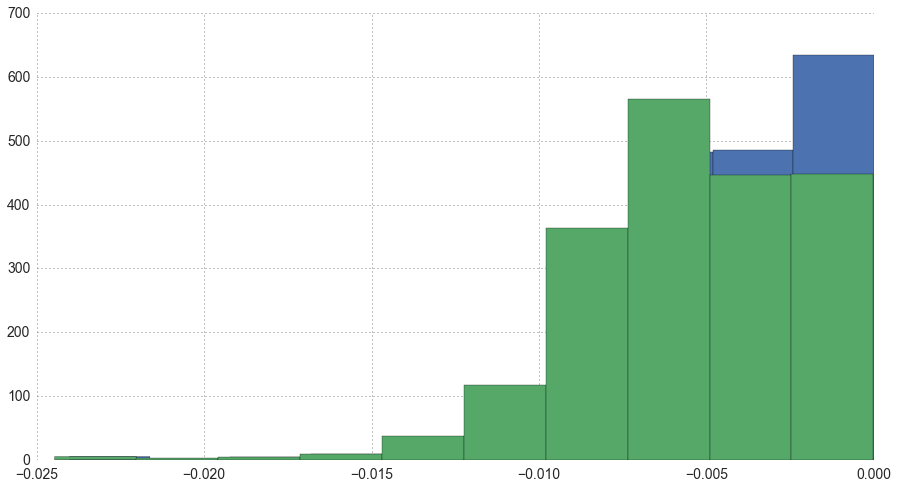

In [22]:
fig, ax = plt.subplots()
ax.hist(solar_params.mu_lease)
ax.hist(solar_params.mu_own)
plt.show()

/Users/johannesmauritzen/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


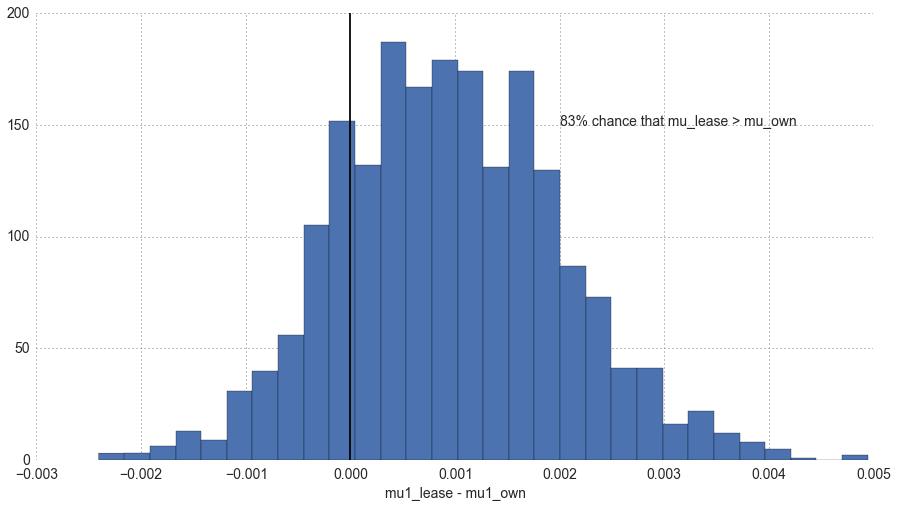

In [23]:
diff_lease = solar_params.mu_lease - solar_params.mu_own
fig, ax = plt.subplots()
ax.hist(diff_lease, bins=30)
ax.vlines(x=0, ymin=0, ymax=200, linestyles = "solid")
ax.text(x=.002, y=150, s="83% chance that mu_lease > mu_own")
ax.set_xlabel("mu1_lease - mu1_own")
plt.show()
fig.savefig("/Users/johannesmauritzen/research/solar_prod/figures/diff_lease.png", dpi=600)


The reason for the big spike at .001 is that this is the difference between two estimates, and that the simulated distribution for mu_lease had a higher number of simulations close to zero. 

In [24]:
len(diff_lease[diff_lease>0])/len(diff_lease)

0.806

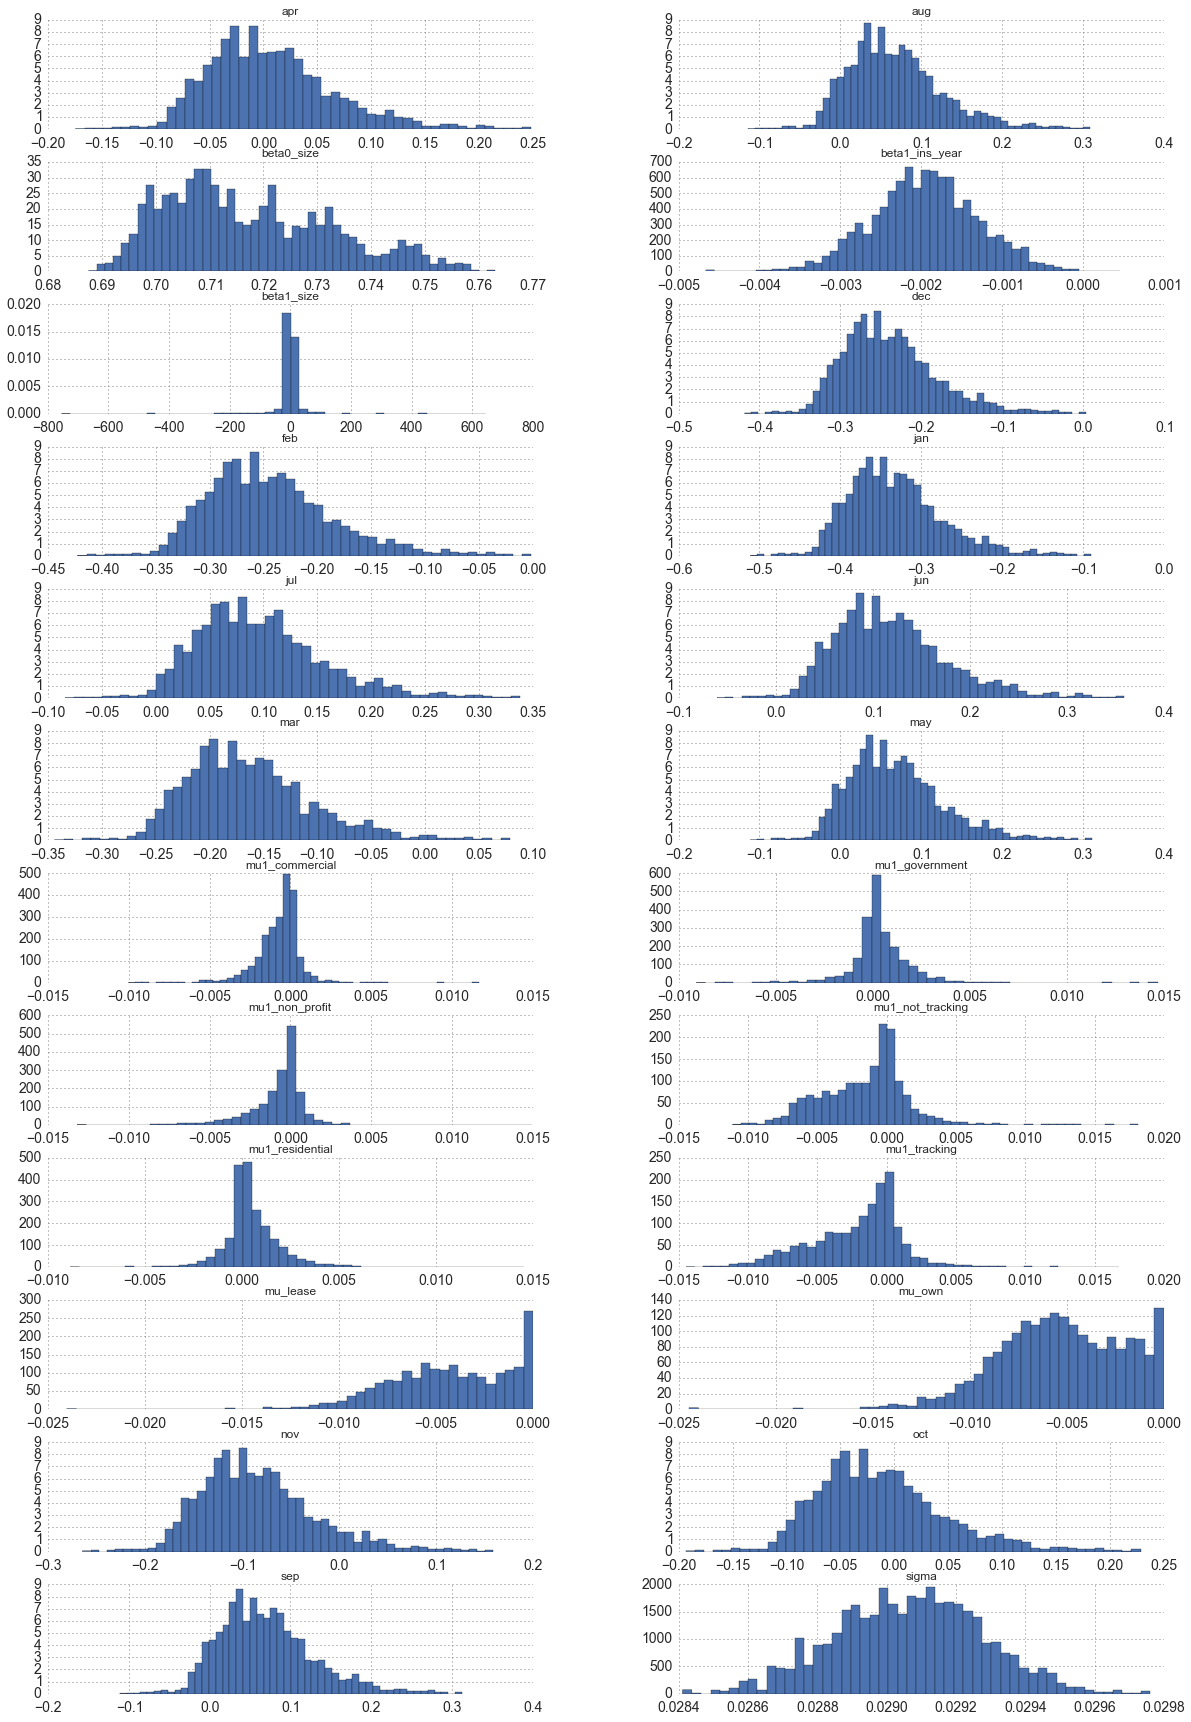

In [25]:
param_plot = plt.subplots(12, 2, figsize=(20,30))
solar_params.hist(ax = param_plot[1],  bins=50, normed=True)
plt.show()

In [26]:
def summary_info(post_sample, lim=5):	
	#post_sample = solar_params
	#lim=5
	"""
	Input extracted STAN model sample: post_sample
	lim - confidence interval ie lim = 5 => 95 central posterior interval  
	"""

	params = []
	means = []
	medians = []
	modes = []
	low_ci = []
	high_ci = []
	for i in post_sample:
		param_sim = post_sample[i]
		if (param_sim.shape[0] == param_sim.size):
			params.append(i)
			means.append(np.mean(param_sim))
			medians.append(np.median(param_sim))
			n_samples = len(param_sim)
			n_tail = n_samples*(lim/100)/2
			param_sim=np.sort(param_sim)
			low_ci.append(param_sim[n_tail])
			high_ci.append(param_sim[n_samples-n_tail])
		else:	
			for par_case in param_sim.T:
				params.append(i)
				means.append(np.mean(par_case))
				medians.append(np.median(par_case))
				modes.append(np.mode(parcase))
				n_samples = len(par_case)
				n_tail = n_samples*(lim/100)/2
				par_case=np.sort(par_case)
				low_ci.append(par_case[n_tail])
				high_ci.append(par_case[n_samples-n_tail])
	output = {"params":params,
		"means" : means,
		"medians" : medians,
		"low_ci" : low_ci,
		"high_ci" : high_ci}
	output = pd.DataFrame(output)
	return(output)


In [27]:
cols = ["mu_own", "mu_lease", "beta0_size","beta1_size",  "beta1_ins_year", "mu1_commercial","mu1_government", 
        "mu1_residential","mu1_non_profit", "mu1_not_tracking",  "mu1_tracking",
        "sigma", "jan", "feb",
 "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", 
 "nov", "dec"]

#solar_params = solar_params[cols]
summary_table=summary_info(solar_params)
summary_table = summary_table.set_index("params")


/Users/johannesmauritzen/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/johannesmauritzen/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [54]:
sd_mon_op = np.std(solar_data["months_operation"])
mean_mon_op = np.mean(solar_data["months_operation"])

#format function
def f1(x):
    return '%1.4f' % x
summary_table.to_latex(buf="table.tex", float_format=f1)

#prediction
def stanPred(p):
	fitted =medParam["jul"] + p * ((op_time-mean_mon_op)/sd_mon_op)
	return(pd.Series({"fitted":fitted}))


In [66]:
op_time = np.arange(1,240)

#med parameters:
medParam = solar_params[["jul", "mu_own", "mu_lease"]].median()

yhat_own = np.exp(stanPred(medParam["mu_own"])[0])
yhat_own = yhat_own/yhat_own[0]*100

yhat_lease = np.exp(stanPred(medParam["mu_lease"])[0])
yhat_lease = yhat_lease/yhat_lease[0]*100


In [67]:
#predicted values for each chain:
chain_pred_own = solar_params["mu_own"].apply(stanPred)
chain_pred_lease = solar_params["mu_lease"].apply(stanPred)


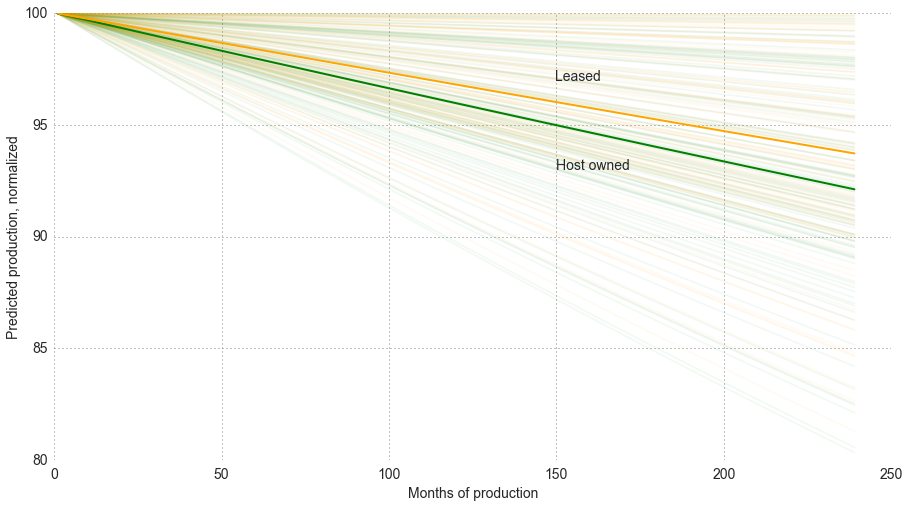

In [72]:
idx = np.random.choice(1999, 100)

fig, ax = plt.subplots()
#plot each chain
for i in range(len(idx)):
	line = np.exp(chain_pred_own.iloc[idx[i],0])
	line = line/line[0]*100
	ax.plot(op_time, line , color="green", alpha=.05, 
		linestyle="-")
for i in range(len(idx)):
	line = np.exp(chain_pred_lease.iloc[idx[i],0])
	line = line/line[0]*100
	ax.plot(op_time, line , color="orange", alpha=.05, 
		linestyle="-")
    
ax.plot(op_time, yhat_own, color="green", lw = 2)
ax.plot(op_time, yhat_lease, color="orange", lw=2)
ax.set_xlabel("Months of production")
ax.set_ylabel("Predicted production, normalized")
ax.text(150,93, "Host owned")
ax.text(150,97, "Leased")
fig.savefig("/Users/johannesmauritzen/research/solar_prod/figures/predicted_deg.png", dpi=600)
